In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
from collections import deque, OrderedDict
import random
import matplotlib.pyplot as plt


class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Outputs Q-values for each action


class MetaQPolicy:
    def __init__(self, policy):
        self.policy = policy
        self.params = OrderedDict(policy.named_parameters())

    def update_params(self, loss, step_size=0.1, first_order=False):
        # Compute gradients
        grads = torch.autograd.grad(loss, self.params.values(), create_graph=not first_order)

        updated_params = OrderedDict()
        for (name, param), grad in zip(self.params.items(), grads):
            # Check if any gradient has NaN values
            if torch.isnan(grad).any():
                print(f"Warning: Gradient for {name} contains NaN values!")

            # Perform gradient descent with gradient clipping
            updated_params[name] = param - step_size * grad.clamp(-5, 5)

        return updated_params

    def set_params(self, params):
        for name, param in self.policy.named_parameters():
            param.data = params[name].data.clone()


class ThompsonMetaQLearning:
    def __init__(self, state_dim, action_dim, hidden_dim=256, inner_lr=7.631606343851303e-05, meta_lr=0.00149595629612992,
                 memory_size=8800, batch_size=240, gamma=0.912242712260521, epsilon=0.8412336683199524, thompson_alpha=1.0937643537131119, thompson_beta=0.37127980073325745):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.meta_policy = MetaQPolicy(self.q_network)
        self.target_network = QNetwork(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.meta_optimizer = optim.Adam(self.q_network.parameters(), lr=meta_lr)
        self.task_memories = {}  # Dictionary to store memory for each task
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon  # Initialize epsilon
        self.inner_lr = inner_lr

        # Thompson sampling parameters
        self.alpha = np.ones(action_dim) * thompson_alpha
        self.beta = np.ones(action_dim) * thompson_beta

    def create_task_memory(self, task_id):
        """Initialize memory for a new task."""
        if task_id not in self.task_memories:
            self.task_memories[task_id] = deque(maxlen=self.memory_size)

    def store_transition(self, task_id, state, action, reward, next_state, done):
        """Store transitions in task-specific memory."""
        if task_id not in self.task_memories:
            self.create_task_memory(task_id)
        self.task_memories[task_id].append((state, action, reward, next_state, done))

        # Update Thompson sampling parameters
        if reward > 0:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

    def prepare_batch(self, batch):
        """Prepare batches for training."""
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        return states, actions, rewards, next_states, dones

    def inner_loop_update(self, task_id):
        """Perform inner-loop update on task-specific memory."""
        memory = self.task_memories[task_id]
        if len(memory) < self.batch_size:
            return None

        batch = random.sample(memory, self.batch_size)
        states, actions, rewards, next_states, dones = self.prepare_batch(batch)

        # Compute Q-values
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            max_next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * (1 - dones) * max_next_q_values

        # Compute loss
        loss = F.mse_loss(q_values, target_q_values)

        # Update parameters
        updated_params = self.meta_policy.update_params(loss, self.inner_lr)
        return updated_params

    def select_action(self, state):
        """Select an action using Thompson sampling and epsilon-greedy exploration."""
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Sample Thompson probabilities
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]
        thompson_probs = np.array([np.random.beta(self.alpha[i], self.beta[i]) for i in range(len(q_values))])
        weighted_q_values = q_values * thompson_probs

        # Epsilon-greedy exploration
        if random.random() < self.epsilon:
            return random.randrange(len(q_values))
        return np.argmax(weighted_q_values)


    def selec_action_thompson(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        # Sample Thompson probabilities
        with torch.no_grad():
            q_values = self.q_network(state).cpu().numpy()[0]
        thompson_probs = np.array([np.random.beta(self.alpha[i], self.beta[i]) for i in range(len(q_values))])
        weighted_q_values = q_values * thompson_probs

        # Epsilon-greedy exploration
        if random.random() < self.epsilon:
            #thomp sampling
            return np.argmax(thompson_probs)
        return np.argmax(weighted_q_values)

    def meta_update(self):
        """Perform meta-update using memories of all tasks."""
        if len(self.task_memories) == 0:
            return

        self.meta_optimizer.zero_grad()
        meta_loss = 0

        # Iterate over each task's memory for meta-learning
        for task_id, memory in self.task_memories.items():
            if len(memory) < self.batch_size * 2:
                continue

            # Sample task and evaluation batches
            task_batch = random.sample(memory, self.batch_size)
            eval_batch = random.sample(memory, self.batch_size)

            updated_params = self.inner_loop_update(task_id)

            if updated_params is None:
                continue

            # Temporarily set updated parameters for evaluation
            original_params = OrderedDict((name, param.clone()) for name, param in self.q_network.named_parameters())
            self.meta_policy.set_params(updated_params)

            # Evaluate on evaluation batch
            states, actions, rewards, next_states, dones = self.prepare_batch(eval_batch)
            q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
            with torch.no_grad():
                max_next_q_values = self.target_network(next_states).max(1)[0]
                target_q_values = rewards + self.gamma * (1 - dones) * max_next_q_values

            # Compute meta-loss
            task_meta_loss = F.mse_loss(q_values, target_q_values)
            meta_loss += task_meta_loss

            # Revert to original parameters
            self.meta_policy.set_params(original_params)

        if meta_loss > 0:
            meta_loss = meta_loss / len(self.task_memories)
            meta_loss.backward()
            self.meta_optimizer.step()

    def update_target_network(self):
        """Update target network with the main Q-network's weights."""
        self.target_network.load_state_dict(self.q_network.state_dict())


import time  # Add this to measure duration for each episode

def train_thompson_meta_q(env_name='CartPole-v1', tasks=5, episodes=1000, max_steps=500, epsilon_search=False):
    """Train Thompson Meta Q-learning with multiple tasks."""
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQLearning(state_dim, action_dim)
    scores_per_task = {task_id: [] for task_id in range(tasks)}
    episode_durations = []  # List to store durations for each episode
    total_scores = []  # List to store aggregated scores per episode

    for episode in range(episodes):
        start_time = time.time()  # Start the timer for the episode
        print(f"Starting Episode {episode + 1}/{episodes}")
        episode_total_score = 0  # Total reward across all tasks for this episode

        for task_id in range(tasks):
            state = env.reset()
            total_reward = 0

            for _ in range(max_steps):
                if epsilon_search:
                    action = agent.select_action(state)
                else:
                    action = agent.selec_action_thompson(state)
                next_state, reward, done, _ = env.step(action)

                agent.store_transition(task_id, state, action, reward, next_state, done)
                total_reward += reward
                state = next_state

                if done:
                    break

            scores_per_task[task_id].append(total_reward)
            episode_total_score += total_reward  # Add task's reward to episode's total score

            # Perform meta-update after each task
            agent.meta_update()

        total_scores.append(episode_total_score)  # Store the total score for the episode
        episode_duration = time.time() - start_time  # Measure the duration
        episode_durations.append(episode_duration)

        # Update target network periodically
        if episode % 10 == 0:
            agent.update_target_network()

        # Decay epsilon
        epsilon_decay = 0.9550477772166409
        agent.epsilon = max(0.1, agent.epsilon * epsilon_decay)

        update_frequency = 1
        # Log progress every update_frequency episodes
        if (episode + 1) % update_frequency == 0:
            avg_scores = {task_id: np.mean(scores_per_task[task_id][-10:]) for task_id in range(tasks)}
            if (episode + 1) % 50 == 0:
              print(f"Episode {episode + 1}, Average Scores: {avg_scores}")
              print(f"Episode {episode + 1} Duration: {episode_duration:.2f}s")

    return agent, scores_per_task, total_scores, episode_durations


def run_thompson_meta_q_multiple_times(env_name='CartPole-v1', runs=5, episodes=500, max_steps=500):
    all_scores = []
    all_durations = []  # Placeholder to store durations for each run

    for run in range(runs):
        print(f"Run {run + 1}/{runs}")
        agent, scores_per_task, total_scores, episode_durations = train_thompson_meta_q(
            env_name=env_name, episodes=episodes, max_steps=max_steps, tasks=n_tasks
        )
        all_scores.append(total_scores)
        all_durations.append(episode_durations)

    # Pad the scores to equal lengths with NaNs for aggregation
    max_len = max(len(scores) for scores in all_scores)
    padded_scores = np.array([np.pad(scores, (0, max_len - len(scores)), constant_values=np.nan) for scores in all_scores])

    # Compute statistics
    median_scores = np.nanmedian(padded_scores, axis=0)
    mean_scores = np.nanmean(padded_scores, axis=0)
    std_scores = np.nanstd(padded_scores, axis=0)

    return {
        'all_scores': all_scores,
        'median_scores': median_scores,
        'mean_scores': mean_scores,
        'std_scores': std_scores,
        'padded_scores': padded_scores,
        'all_durations': all_durations  # Store durations for further analysis
    }


if __name__ == "__main__":
    n_tasks = 5
    torch.manual_seed(1)
    np.random.seed(1)
    random.seed(1)

    stats = run_thompson_meta_q_multiple_times(runs=5, episodes=500)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))





Run 1/5
Starting Episode 1/500
Starting Episode 2/500
Starting Episode 3/500
Starting Episode 4/500
Starting Episode 5/500
Starting Episode 6/500
Starting Episode 7/500


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning:

WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



Starting Episode 8/500
Starting Episode 9/500
Starting Episode 10/500
Starting Episode 11/500
Starting Episode 12/500
Starting Episode 13/500
Starting Episode 14/500
Starting Episode 15/500
Starting Episode 16/500
Starting Episode 17/500
Starting Episode 18/500
Starting Episode 19/500
Starting Episode 20/500
Starting Episode 21/500
Starting Episode 22/500
Starting Episode 23/500
Starting Episode 24/500
Starting Episode 25/500
Starting Episode 26/500
Starting Episode 27/500
Starting Episode 28/500
Starting Episode 29/500
Starting Episode 30/500
Starting Episode 31/500
Starting Episode 32/500
Starting Episode 33/500
Starting Episode 34/500
Starting Episode 35/500
Starting Episode 36/500
Starting Episode 37/500
Starting Episode 38/500
Starting Episode 39/500
Starting Episode 40/500
Starting Episode 41/500
Starting Episode 42/500
Starting Episode 43/500
Starting Episode 44/500
Starting Episode 45/500
Starting Episode 46/500
Starting Episode 47/500
Starting Episode 48/500
Starting Episode 4

<Figure size 1200x600 with 0 Axes>

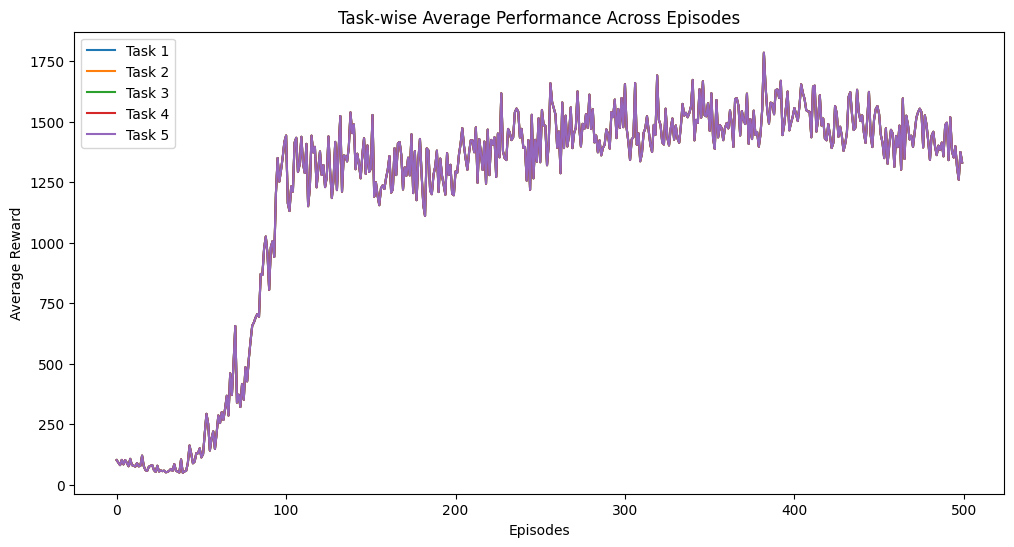

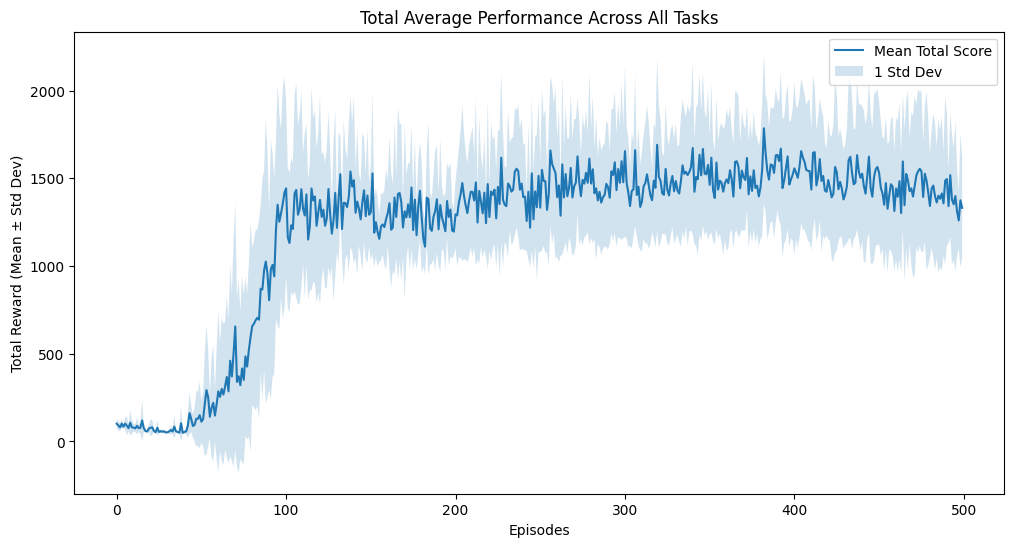

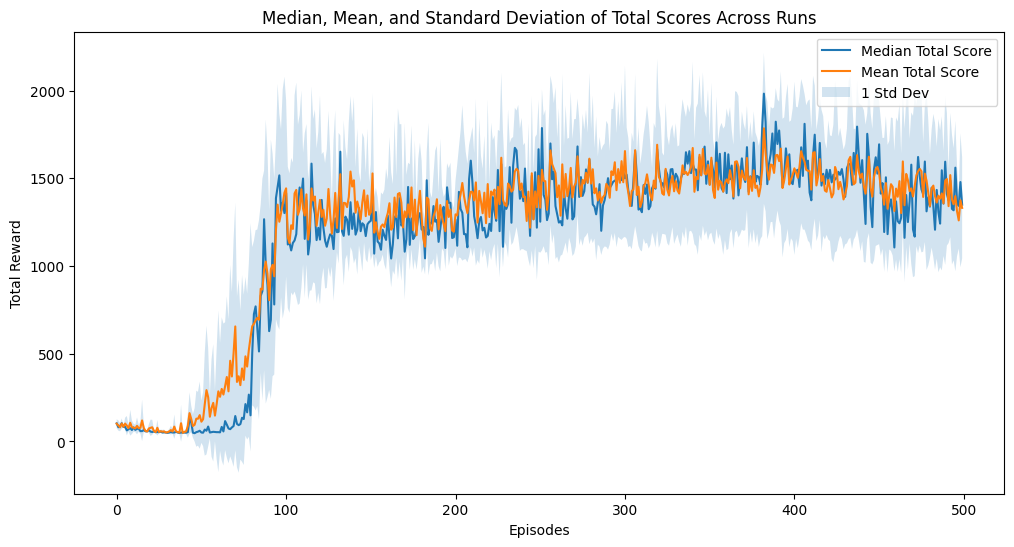

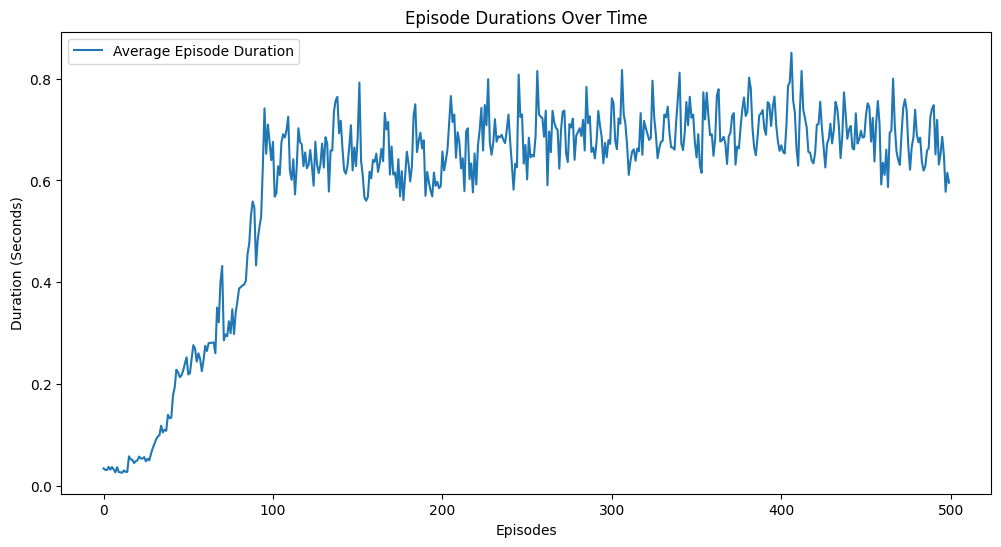

In [20]:
# Import visualization library
import matplotlib.pyplot as plt
import numpy as np

# Unpack statistics
all_scores = stats['all_scores']
median_scores = stats['median_scores']
mean_scores = stats['mean_scores']
std_scores = stats['std_scores']
all_durations = stats['all_durations']
padded_scores = stats['padded_scores']

# 1. Task-wise average performance across episodes
plt.figure(figsize=(12, 6))
for task_id in range(n_tasks):
    task_scores = [np.nanmean([scores[ep] for scores in all_scores if ep < len(scores)])
                   for ep in range(len(mean_scores))]
    plt.plot(task_scores, label=f"Task {task_id+1}")

plt.title("Task-wise Average Performance Across Episodes")
plt.xlabel("Episodes")
plt.ylabel("Average Reward")
plt.legend()
plt.show()

# 2. Total average performance across all tasks
plt.figure(figsize=(12, 6))
plt.plot(mean_scores, label="Mean Total Score")
plt.fill_between(range(len(mean_scores)),
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 alpha=0.2, label="1 Std Dev")
plt.title("Total Average Performance Across All Tasks")
plt.xlabel("Episodes")
plt.ylabel("Total Reward (Mean ± Std Dev)")
plt.legend()
plt.show()

# 3. Median, mean, and standard deviation of total scores across runs
plt.figure(figsize=(12, 6))
plt.plot(median_scores, label="Median Total Score")
plt.plot(mean_scores, label="Mean Total Score")
plt.fill_between(range(len(mean_scores)),
                 mean_scores - std_scores,
                 mean_scores + std_scores,
                 alpha=0.2, label="1 Std Dev")
plt.title("Median, Mean, and Standard Deviation of Total Scores Across Runs")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()
plt.show()

# 4. Episode durations
avg_durations = np.mean(all_durations, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(avg_durations, label="Average Episode Duration")
plt.title("Episode Durations Over Time")
plt.xlabel("Episodes")
plt.ylabel("Duration (Seconds)")
plt.legend()
plt.show()


In [12]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 8.4 MB/s eta 0:00:00


[I 2024-12-06 14:34:57,367] A new study created in memory with name: no-name-c85b6dca-1bae-4ccd-83d1-8b48b5327a00
<ipython-input-13-ac9a3c55e184>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  inner_lr = trial.suggest_loguniform("inner_lr", 1e-5, 1e-1)
<ipython-input-13-ac9a3c55e184>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  meta_lr = trial.suggest_loguniform("meta_lr", 1e-5, 1e-2)
<ipython-input-13-ac9a3c55e184>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  thompson_alpha = trial.suggest_uniform("thompson_alpha", 0.

Best trial:
  Value: 467.9
  Params: 
    hidden_dim: 256
    inner_lr: 7.631606343851303e-05
    meta_lr: 0.00149595629612992
    thompson_alpha: 1.0937643537131119
    thompson_beta: 0.37127980073325745
    epsilon: 0.8412336683199524
    epsilon_decay: 0.9550477772166409
    batch_size: 240
    memory_size: 8800
    gamma: 0.912242712260521
    meta_update_frequency: 1


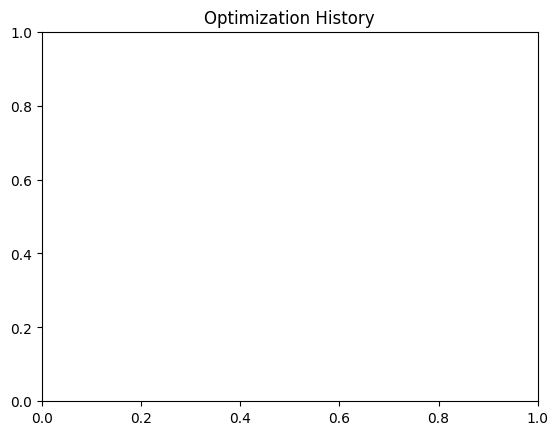

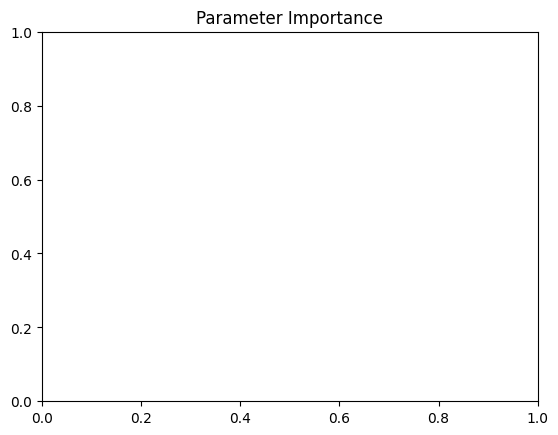

In [13]:
import optuna
import matplotlib.pyplot as plt

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256, step=32)
    inner_lr = trial.suggest_loguniform("inner_lr", 1e-5, 1e-1)
    meta_lr = trial.suggest_loguniform("meta_lr", 1e-5, 1e-2)
    thompson_alpha = trial.suggest_uniform("thompson_alpha", 0.1, 2.0)
    thompson_beta = trial.suggest_uniform("thompson_beta", 0.1, 2.0)
    epsilon = trial.suggest_uniform("epsilon", 0.1, 1.0)  # Epsilon initial value
    epsilon_decay = trial.suggest_uniform("epsilon_decay", 0.95, 0.999)
    batch_size = trial.suggest_int("batch_size", 8, 256, step=8)
    memory_size = trial.suggest_int("memory_size", 1000, 10000, step=100)
    gamma = trial.suggest_uniform("gamma", 0.9, 0.999)
    meta_update_frequency = trial.suggest_int("meta_update_frequency", 1, 10)  # Frequency of meta-update

    # Initialize environment and agent with sampled hyperparameters
    env_name = "CartPole-v1"
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = ThompsonMetaQLearning(
        state_dim=state_dim,
        action_dim=action_dim,
        hidden_dim=hidden_dim,
        inner_lr=inner_lr,
        meta_lr=meta_lr,
        thompson_alpha=thompson_alpha,
        thompson_beta=thompson_beta,
        batch_size=batch_size,
        memory_size=memory_size,
        gamma=gamma,
        epsilon=epsilon,  # Pass the tuned epsilon value
    )

    episodes = 500
    max_steps = 500
    scores = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            agent.store_transition(0, state, action, reward, next_state, done)  # Task ID is fixed to 0 for simplicity
            total_reward += reward
            state = next_state

            if done:
                break

        scores.append(total_reward)

        # Perform meta-update only at specified frequency
        if (episode + 1) % meta_update_frequency == 0:
            agent.meta_update()

        # Update target network periodically
        if episode % 10 == 0:
            agent.update_target_network()

        # Decay epsilon
        agent.epsilon = max(0.1, agent.epsilon * epsilon_decay)

    # Objective: maximize the mean reward over the last 10 episodes
    return np.mean(scores[-10:])


# Run Optuna study
def optimize_hyperparameters():
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    return study

if __name__ == "__main__":
    study = optimize_hyperparameters()

    # Plot optimization history
    optuna.visualization.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    # Plot parameter importance
    optuna.visualization.plot_param_importances(study)
    plt.title("Parameter Importance")
    plt.show()